
--- Data Initialization ---
Matrix A shape: (4, 2)
Matrix A content:
 [[1.  2. ]
 [1.  3. ]
 [1.  4.5]
 [1.  5.5]]

--- Solving with Normal Equation ---
Condition Number: 155.1056
Calculated Theta (Normal Equation):
 [[-1.04137931]
 [ 2.03103448]]

--- Solving with Batch Gradient Descent ---
Final MSE: 0.059754
Calculated Theta (BGD):
 [[-0.38222724]
 [ 1.87426173]]


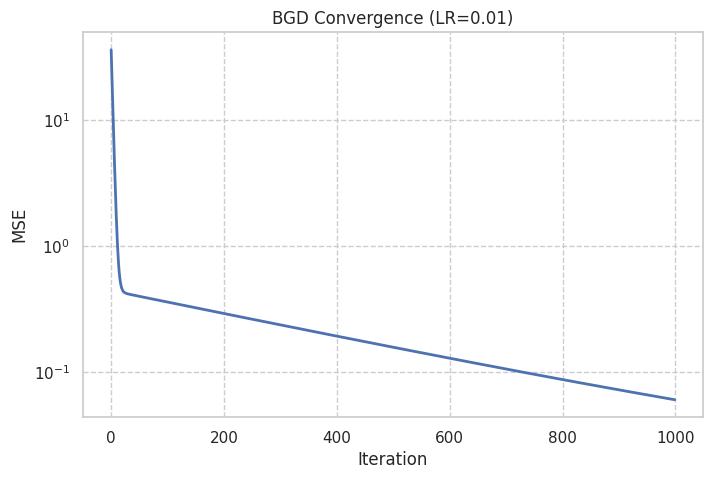

Plotting Phase 1 Trajectory...


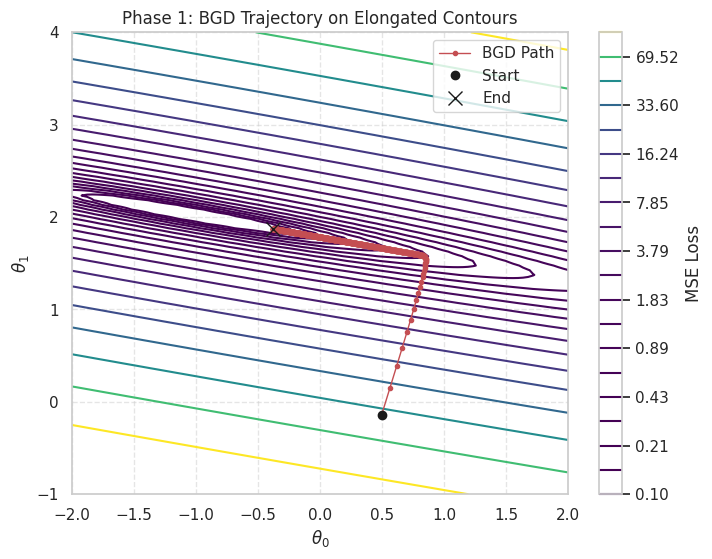


--- Solving with SVD ---
Singular Values: [8.18948109 0.65757094]
Calculated Theta (SVD):
 [[-1.04137931]
 [ 2.03103448]]

--- Stability Analysis (Collinearity Injection) ---
A_collinear shape: (4, 3)

--- Solving with Normal Equation ---
Condition Number: 1265447694625.0647
Calculated Theta (Normal Equation):
 [[ 1.07124800e-01]
 [ 1.04108101e+04]
 [-1.04089714e+04]]

--- Solving with SVD ---
Singular Values: [1.14261420e+01 6.66515676e-01 1.01574817e-05]
Stability Mode (rcond=0.1): Cutoff=1.1426e+00, Truncated 2 values.
Calculated Theta (SVD):
 [[0.20568877]
 [0.86770178]
 [0.86770845]]


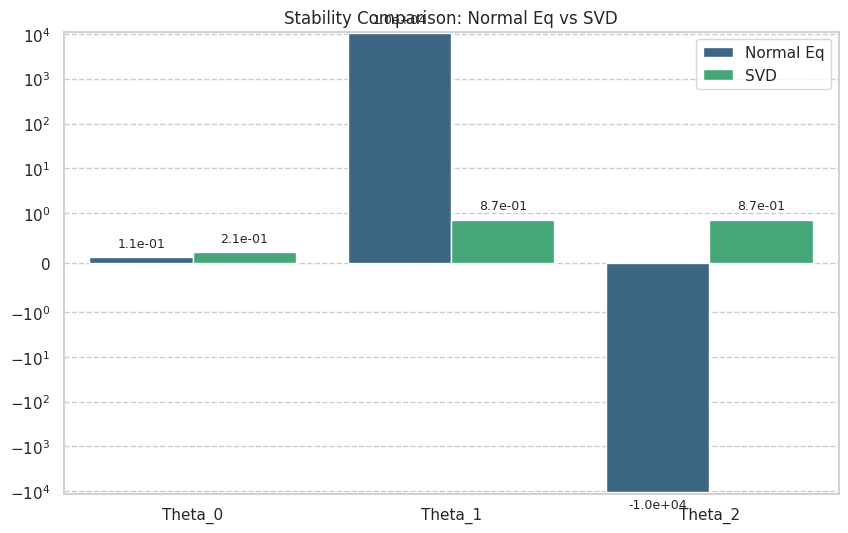

In [14]:
# Phase 1: Numerical Stability and Small Data Analysis
# ------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numpy.linalg import inv, pinv, svd, cond
import os

def setup_environment():
    os.makedirs('report/results', exist_ok=True)
    np.random.seed(42)
    sns.set_theme(style="whitegrid")
    plt.rcParams['figure.figsize'] = (10, 6)

def create_dataset():
    print("\n--- Data Initialization ---")
    A = np.array([[1, 2.0], [1, 3.0], [1, 4.5], [1, 5.5]])
    y = np.array([[3.1], [4.9], [8.2], [10.1]])
    print(f"Matrix A shape: {A.shape}")
    print("Matrix A content:\n", A)
    return A, y

# Solver Functions
def solve_normal_equation(A, y):
    print(f"\n--- Solving with Normal Equation ---")
    cond_num = cond(A.T @ A)
    print(f"Condition Number: {cond_num:.4f}")
    try:
        theta = inv(A.T @ A) @ A.T @ y
        print(f"Calculated Theta (Normal Equation):\n", theta)
        return theta
    except Exception as e:
        print("Normal Equation Failed:", e)
        return None

def solve_bgd(A, y, lr=0.01, iterations=1000):
    print("\n--- Solving with Batch Gradient Descent ---")
    m = len(y)
    theta = np.random.randn(A.shape[1], 1)
    loss_history = []
    theta_history = [theta.copy()]

    for _ in range(iterations):
        gradients = (1/m) * A.T @ (A @ theta - y)
        theta = theta - lr * gradients
        loss = np.mean((A @ theta - y)**2)
        loss_history.append(loss)
        theta_history.append(theta.copy())

    print(f"Final MSE: {loss_history[-1]:.6f}")
    print("Calculated Theta (BGD):\n", theta)
    
    # Plot Convergence
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, linewidth=2)
    plt.title(f"BGD Convergence (LR={lr})")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.yscale('log')
    plt.grid(True, linestyle='--')
    plt.savefig('report/results/bgd_convergence.png')
    plt.show()
    
    return theta, theta_history

def solve_svd(A, y, rcond=None):
    print(f"\n--- Solving with SVD ---")
    #Decompose A into U, S, Vt using SVD
    U, S, Vt = svd(A, full_matrices=False)
    print(f"Singular Values: {S}")
    
    # 2. Calculate cutoff strictly like pinv
    # pinv cutoff: rcond * max(S)
    max_s = np.max(S) if S.size > 0 else 0
    if rcond is None:
        # Default machine precision behavior of pinv
        cutoff = 1e-15 * max_s
    else:
        cutoff = rcond * max_s
        
    # 3. Invert Singular Values with Cutoff
    S_inv = np.zeros_like(S)
    mask = S > cutoff
    S_inv[mask] = 1.0 / S[mask]
    
    if rcond:
        print(f"Stability Mode (rcond={rcond}): Cutoff={cutoff:.4e}, Truncated {np.sum(~mask)} values.")
    
    # 4. Construct Pseudo-Inverse: A_plus = Vt.T @ S_inv @ U.T
    A_plus = Vt.T @ np.diag(S_inv) @ U.T
    
    # 5. Calculate Theta
    theta = A_plus @ y
    
    print(f"Calculated Theta (SVD):\n", theta)
    return theta

def run_stability_test(A, y):
    print("\n--- Stability Analysis (Collinearity Injection) ---")
    m = len(y)
    noise = np.random.rand(m, 1) * 0.0001
    A_coll = np.hstack((A, A[:, [1]] + noise))
    print(f"A_collinear shape: {A_coll.shape}")

    # Normal Equation
    theta_ne = solve_normal_equation(A_coll, y)

    # SVD 
    theta_svd = solve_svd(A_coll, y, rcond=1e-1)

    methods = ['Normal Eq'] * 3 + ['SVD'] * 3
    coeffs = ['Theta_0', 'Theta_1', 'Theta_2'] * 2
    values = list(theta_ne.ravel()) + list(theta_svd.ravel())

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=coeffs, y=values, hue=methods, palette='viridis')
    plt.title("Stability Comparison: Normal Eq vs SVD")
    plt.yscale('symlog', linthresh=1)
    plt.grid(True, axis='y', linestyle='--')
    
    for p in ax.patches:
        height = p.get_height()
        if abs(height) > 1e-3:
            ax.annotate(f'{height:.1e}', (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom' if height > 0 else 'top', 
                        xytext=(0, 5 if height > 0 else -5), 
                        textcoords='offset points', fontsize=9)
            
    plt.savefig('report/results/stability_comparison.png')
    plt.show()


def plot_phase1_trajectory(A, y, theta_history):
    print("Plotting Phase 1 Trajectory...")
    t0 = np.linspace(-2, 2, 100)
    t1 = np.linspace(-1, 4, 100)
    T0, T1 = np.meshgrid(t0, t1)
    Z = np.zeros_like(T0)
    
    for i in range(T0.shape[0]):
        for j in range(T0.shape[1]):
            t = np.array([[T0[i,j]], [T1[i,j]]])
            Z[i,j] = np.mean((A @ t - y)**2)
            
    plt.figure(figsize=(8, 6))
    
    plt.contour(T0, T1, Z, levels=np.logspace(-1, 2, 20), cmap='viridis')
    plt.colorbar(label='MSE Loss')

    path = np.array(theta_history)
    plt.plot(path[:, 0], path[:, 1], 'r-o', markersize=3, linewidth=1, label='BGD Path')
    plt.plot(path[0, 0], path[0, 1], 'ko', label='Start')
    plt.plot(path[-1, 0], path[-1, 1], 'kx', markersize=10, label='End')
    
    plt.title("Phase 1: BGD Trajectory on Elongated Contours")
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig('report/results/phase1_bgd_trajectory.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    setup_environment()
    A, y = create_dataset()
    
    solve_normal_equation(A, y)
    theta_bgd, history_bgd = solve_bgd(A, y)
    plot_phase1_trajectory(A, y, history_bgd)
    solve_svd(A, y)
    
    run_stability_test(A, y)



--- Loading Auto MPG Dataset ---
Data loaded. Shape: (392, 2) (y = theta0 + theta1 * HP)

--- Running Advanced Comparison ---
Running BGD...
BGD Total Time: 0.0113s | Final Cost: 23.9437

Running SGD...
SGD Total Time: 0.0609s | Final Cost: 24.0341

--- Efficiency Analysis (Time to Reach Loss < 25) ---
BGD: Reached at iter 316 (~0.0046s)
SGD: Reached at iter 306 (~0.0045s)


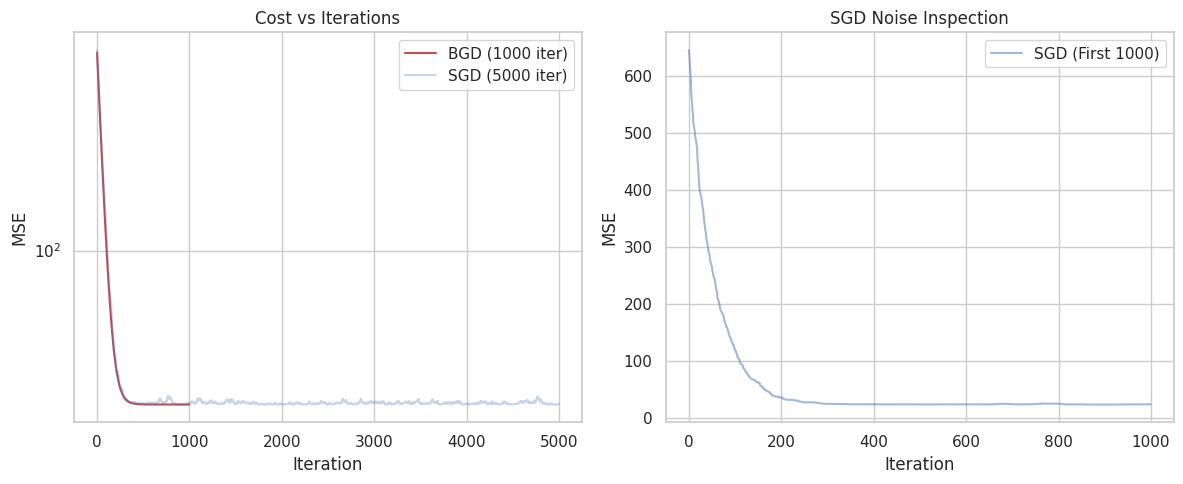

Saved: report/results/optimization_trajectory.png


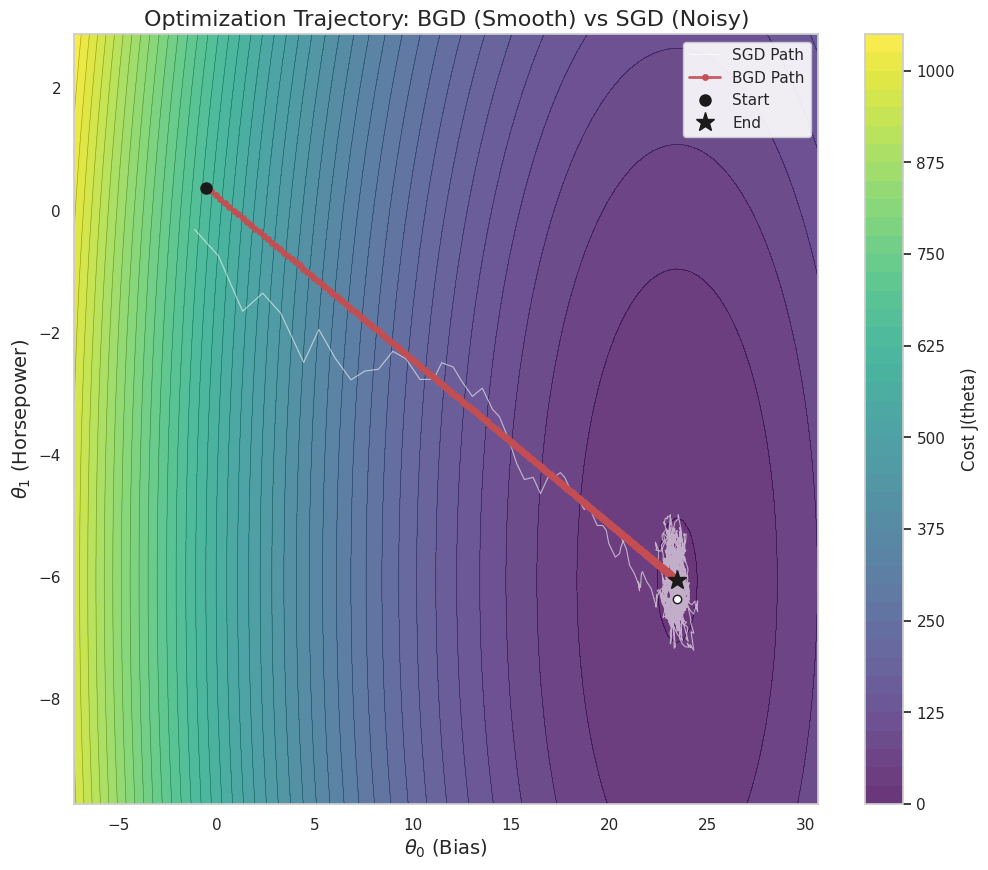


Plots saved to report/results/


In [19]:
# Phase 2: Scalability Analysis 
# ------------------------------------------------------
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns


def load_autompg_strict():
    print("\n--- Loading Auto MPG Dataset ---")
    url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    cols = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Year', 'Origin']
    
    try:
        df = pd.read_csv(url, names=cols, na_values="?", comment='\t', sep=" ", skipinitialspace=True)
        df = df.dropna()
        
        # Target: MPG
        y = df['MPG'].values.reshape(-1, 1)
        
        X_raw = df[['Horsepower']].values
        
        # Normalize Features (Critical)
        mu = np.mean(X_raw, axis=0)
        sigma = np.std(X_raw, axis=0)
        X_norm = (X_raw - mu) / sigma
        
        # Add Bias term
        m = len(y)
        X = np.c_[np.ones((m, 1)), X_norm]
        
        print(f"Data loaded. Shape: {X.shape} (y = theta0 + theta1 * HP)")
        return X, y
    except Exception as e:
        print("Error:", e)
        return None, None


def run_bgd(X, y, lr=0.01, iterations=1000):
    m = len(y)
    theta = np.random.randn(X.shape[1], 1)
    path = [theta.copy()] 
    cost_history = []
    time_history = []
    
    start_time = time.time()
    for _ in range(iterations):
        gradients = (1/m) * X.T @ (X @ theta - y)
        theta = theta - lr * gradients
        
        # Record metrics
        path.append(theta.copy())
        cost = np.mean((X @ theta - y)**2)
        cost_history.append(cost)
        time_history.append(time.time() - start_time)
        
    return np.array(path), cost_history, time_history


def run_sgd(X, y, lr=0.01, iterations=5000):
    m = len(y)
    theta = np.random.randn(X.shape[1], 1)
    path = [theta.copy()]
    cost_history = []
    time_history = []
    
    start_time = time.time()
    for _ in range(iterations):
        # Pick random index
        idx = np.random.randint(m)
        xi = X[idx:idx+1]
        yi = y[idx:idx+1]
        
        gradients = xi.T @ (xi @ theta - yi)
        theta = theta - lr * gradients
        
        path.append(theta.copy())
        cost = np.mean((X @ theta - y)**2) 
        cost_history.append(cost)
        time_history.append(time.time() - start_time)
        
    return np.array(path), cost_history, time_history


def plot_optimization_trajectory(X, y, bgd_theta_history, sgd_theta_history):
    bgd_arr = np.array(bgd_theta_history)
    sgd_arr = np.array(sgd_theta_history)
    

    all_theta0 = np.concatenate([bgd_arr[:, 0], sgd_arr[:, 0]])
    all_theta1 = np.concatenate([bgd_arr[:, 1], sgd_arr[:, 1]])
    

    margin_t0 = (all_theta0.max() - all_theta0.min()) * 0.2 + 1.0
    margin_t1 = (all_theta1.max() - all_theta1.min()) * 0.2 + 1.0
    
    t0_min, t0_max = all_theta0.min() - margin_t0, all_theta0.max() + margin_t0
    t1_min, t1_max = all_theta1.min() - margin_t1, all_theta1.max() + margin_t1

    theta0_vals = np.linspace(t0_min, t0_max, 100)
    theta1_vals = np.linspace(t1_min, t1_max, 100)
    T0, T1 = np.meshgrid(theta0_vals, theta1_vals)
    Z = np.zeros(T0.shape)

    for i in range(T0.shape[0]):
        for j in range(T0.shape[1]):
            t = np.array([[T0[i, j]], [T1[i, j]]])
            Z[i, j] = np.mean((X @ t - y)**2)

    plt.figure(figsize=(12, 10))
    
    cntr = plt.contourf(T0, T1, Z, levels=50, cmap='viridis', alpha=0.8)
    cbar = plt.colorbar(cntr)
    cbar.set_label("Cost J(theta)", fontsize=12)
    
    plt.contour(T0, T1, Z, levels=50, colors='k', linewidths=0.5, alpha=0.3)
    
    sgd_vis = sgd_arr[::5] if len(sgd_arr) > 5000 else sgd_arr
    plt.plot(sgd_vis[:, 0], sgd_vis[:, 1], color='white', linewidth=0.8, alpha=0.6, label='SGD Path')

    plt.plot(sgd_arr[-1, 0], sgd_arr[-1, 1], 'wo', markersize=6, markeredgecolor='k')

    plt.plot(bgd_arr[:, 0], bgd_arr[:, 1], 'r-o', markersize=4, linewidth=2, label='BGD Path', alpha=0.9)

    plt.plot(bgd_arr[0, 0], bgd_arr[0, 1], 'ko', markersize=8, label='Start')

    plt.plot(bgd_arr[-1, 0], bgd_arr[-1, 1], 'k*', markersize=14, label='End')
    
    plt.title("Optimization Trajectory: BGD (Smooth) vs SGD (Noisy)", fontsize=16)
    plt.xlabel(r"$\theta_0$ (Bias)", fontsize=14)
    plt.ylabel(r"$\theta_1$ (Horsepower)", fontsize=14)
    plt.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9)
    plt.grid(False)
    
    save_path_traj = os.path.join("report/results/", 'optimization_trajectory.png')
    plt.savefig(save_path_traj, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path_traj}")
    plt.show()
    
    
def plot_convergence_comparison(cost_bgd, cost_sgd):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(cost_bgd, 'r-', label='BGD (1000 iter)')
    plt.plot(cost_sgd, 'b-', alpha=0.3, label='SGD (5000 iter)')
    plt.title("Cost vs Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.yscale('log')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cost_sgd[:1000], 'b-', alpha=0.5, label='SGD (First 1000)')
    plt.title("SGD Noise Inspection")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('report/results/convergence_comparison.png')
    plt.show()


X, y = load_autompg_strict()

if X is not None:
    print("\n--- Running Advanced Comparison ---")
    
    # BGD
    print("Running BGD...")
    start = time.time()
    path_bgd, cost_bgd, time_bgd = run_bgd(X, y)
    bgd_duration = time.time() - start
    print(f"BGD Total Time: {bgd_duration:.4f}s | Final Cost: {cost_bgd[-1]:.4f}")
    
    # SGD
    print("\nRunning SGD...")
    start = time.time()
    path_sgd, cost_sgd, time_sgd = run_sgd(X, y)
    sgd_duration = time.time() - start
    print(f"SGD Total Time: {sgd_duration:.4f}s | Final Cost: {cost_sgd[-1]:.4f}")
    
    # Convergence Analysis
    target_loss = 25.0
    bgd_conv_step = next((i for i, c in enumerate(cost_bgd) if c < target_loss), None)
    sgd_conv_step = next((i for i, c in enumerate(cost_sgd) if c < target_loss), None)
    
    print("\n--- Efficiency Analysis (Time to Reach Loss < 25) ---")
    if bgd_conv_step:
        print(f"BGD: Reached at iter {bgd_conv_step} (~{time_bgd[bgd_conv_step]:.4f}s)")
    else:
        print("BGD: Did not reach target loss.")
        
    if sgd_conv_step:
        print(f"SGD: Reached at iter {sgd_conv_step} (~{time_sgd[sgd_conv_step]:.4f}s)")
    else:
        print("SGD: Did not reach target loss.")
    
    plot_convergence_comparison(cost_bgd, cost_sgd)
    plot_optimization_trajectory(X, y, path_bgd, path_sgd)
    print("\nPlots saved to report/results/")


Training Done in 0.2232s.
MSE: 19.2115
R^2 Score: 0.6838 (Explained Variance)
Coefficients: [ 23.46556137 -17.66094083  12.27826751]
Enhanced plot saved to: report/results/polynomial_analysis_full.png


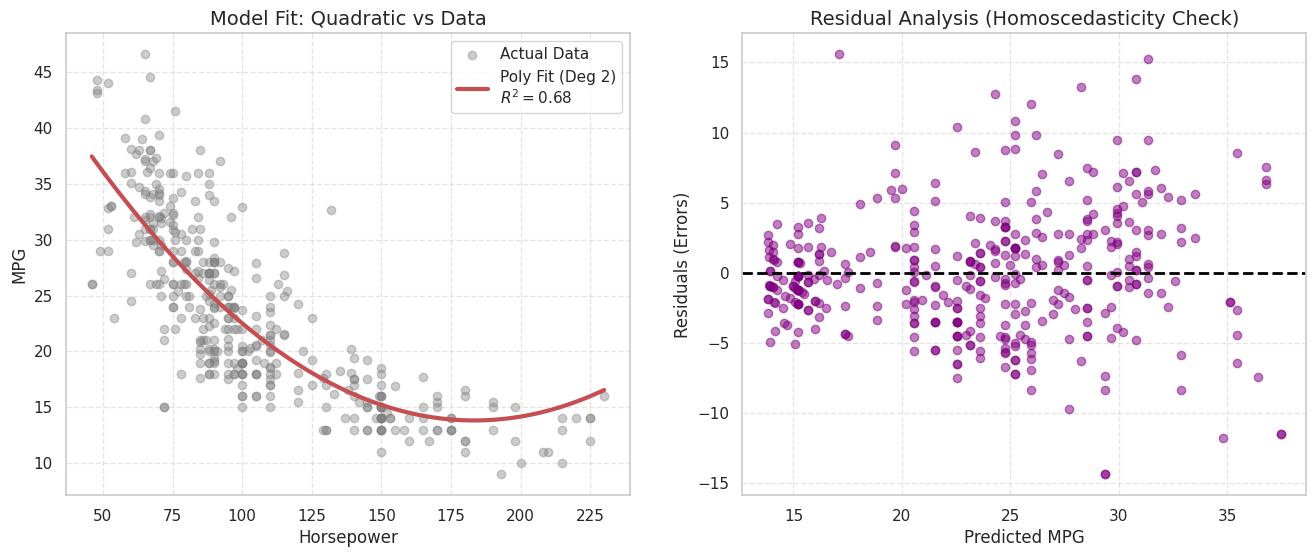

In [ ]:

# Phase 3: Non-linear Regression (Polynomial) 
# ------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time


def calculate_mse_poly(X, y, theta):
    return np.mean((X @ theta - y)**2)

def run_sgd_poly(X, y, learning_rate=0.01, n_epochs=100):
    m, d = X.shape
    theta = np.random.randn(d, 1)
    loss_history = []
    start_time = time.time()
    for epoch in range(n_epochs):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        for i in range(m):
            xi = X_shuffled[i:i+1]
            yi = y_shuffled[i:i+1]
            gradients = xi.T @ (xi @ theta - yi)
            theta = theta - learning_rate * gradients
        loss_history.append(calculate_mse_poly(X, y, theta))
    return theta, loss_history, time.time() - start_time

def run_polynomial_regression_pipeline():
    # Load Data
    url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    df = pd.read_csv(url, names=['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Year', 'Origin', 'CarName'],
                     na_values="?", comment='\t', sep=" ", skipinitialspace=True)
    df = df.dropna(subset=['Horsepower'])
    x_raw = df['Horsepower'].values
    y = df['MPG'].values.reshape(-1, 1)
    
    # Feature Engineering & Normalization
    x_poly_1 = x_raw
    x_poly_2 = x_raw ** 2
    
    mu1, sig1 = np.mean(x_poly_1), np.std(x_poly_1)
    mu2, sig2 = np.mean(x_poly_2), np.std(x_poly_2)
    
    x1_norm = (x_poly_1 - mu1) / sig1
    x2_norm = (x_poly_2 - mu2) / sig2
    
    X_poly = np.c_[np.ones(len(y)), x1_norm, x2_norm]
    
    # Train
    theta_opt, losses, duration = run_sgd_poly(X_poly, y, learning_rate=0.01, n_epochs=200)
    
    # Advanced Metrics (R-squared)
    y_pred_train = X_poly @ theta_opt
    ss_tot = np.sum((y - np.mean(y))**2)
    ss_res = np.sum((y - y_pred_train)**2)
    r2_score = 1 - (ss_res / ss_tot)
    
    print(f"Training Done in {duration:.4f}s.")
    print(f"MSE: {losses[-1]:.4f}")
    print(f"R^2 Score: {r2_score:.4f} (Explained Variance)")
    print(f"Coefficients: {theta_opt.ravel()}")
    
    # Visualization 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot Curve Fit
    ax1.scatter(x_raw, y, alpha=0.4, color='gray', label='Actual Data')
    
    # Generate smooth curve
    x_range = np.linspace(x_raw.min(), x_raw.max(), 100)
    x_r1_norm = (x_range - mu1) / sig1
    x_r2_norm = (x_range**2 - mu2) / sig2
    X_range = np.c_[np.ones(100), x_r1_norm, x_r2_norm]
    y_pred_curve = X_range @ theta_opt
    
    ax1.plot(x_range, y_pred_curve, 'r-', linewidth=3, label=f'Poly Fit (Deg 2)\n$R^2={r2_score:.2f}$')
    ax1.set_title("Model Fit: Quadratic vs Data", fontsize=14)
    ax1.set_xlabel("Horsepower")
    ax1.set_ylabel("MPG")
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Residual Analysis
    residuals = y - y_pred_train
    ax2.scatter(y_pred_train, residuals, alpha=0.5, color='purple')
    ax2.axhline(0, color='black', linestyle='--', linewidth=2)
    ax2.set_title("Residual Analysis (Homoscedasticity Check)", fontsize=14)
    ax2.set_xlabel("Predicted MPG")
    ax2.set_ylabel("Residuals (Errors)")
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # Save
    results_dir = 'report/results'
    os.makedirs(results_dir, exist_ok=True)
    save_path = os.path.join(results_dir, 'polynomial_analysis_full.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"plot saved to: {save_path}")
    plt.show()

if __name__ == "__main__":
    run_polynomial_regression_pipeline()
